In [1]:
import os
from typing import Any

import numpy as np
import time

from pytorch_lightning.utilities.types import STEP_OUTPUT
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

C:\Users\goras\AppData\Roaming\Python\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
train_embeddings = os.path.realpath("../assets/annotated_corpus/train_embeddings.tsv")
test_embeddings = os.path.realpath("../assets/annotated_corpus/test_embeddings.tsv")
topics = os.listdir(os.path.realpath("../assets/annotated_corpus/train"))

In [3]:
def prepare_dataset(filename):
    x_raw = []
    y_raw = []
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            y_raw.append(topics.index(line.split("\t", 1)[0].split("\\")[0]))
            x_raw.append(list(map(float, line.split("\t", 1)[1].split("\t"))))
            
    return np.array(x_raw), np.array(y_raw)

In [4]:
x_train, y_train = prepare_dataset(train_embeddings)
x_test, y_test = prepare_dataset(test_embeddings)

In [5]:
clf1 = SVC()

In [6]:
clf1.fit(x_train, y_train)

SVC()

In [7]:
preds = clf1.predict(x_test)

In [8]:
def calculate_raw_metrics(pred, gt):
    metrics_dict = {}
    if pred.shape != gt.shape:
        raise RuntimeError("Shapes doesn't fit")
    for i in gt:
        if i not in metrics_dict.keys():
             metrics_dict[i] = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
    for i in range(pred.shape[0]):
        if pred[i] == gt[i]:
            metrics_dict[gt[i]]["tp"] += 1
            for j in metrics_dict.keys():
                if j != gt[i]:
                    metrics_dict[j]["tn"] += 1
        else:
            metrics_dict[pred[i]]["fp"] += 1
            metrics_dict[gt[i]]["fn"] += 1
    
    return metrics_dict
         

In [9]:
def calculate_metrics(pred, gt):
    raw_dict = calculate_raw_metrics(pred, gt)
    metrics_dict = {}
    global_tp = 0
    global_fp = 0
    global_tn = 0
    global_fn = 0
    metrics_dict["precision_macro"] = 0
    metrics_dict["recall_macro"] = 0
    metrics_dict["f1_macro"] = 0
    for i in raw_dict.keys():
        metrics_dict[i] = {}
        metrics_dict[i]["precision"] = raw_dict[i]["tp"] / (raw_dict[i]["tp"] + raw_dict[i]["fp"])
        metrics_dict[i]["recall"] = raw_dict[i]["tp"] / (raw_dict[i]["tp"] + raw_dict[i]["fn"])
        metrics_dict[i]["f1"] = 2 * raw_dict[i]["tp"] / (2 * raw_dict[i]["tp"] + raw_dict[i]["fp"] + raw_dict[i]["fn"])
        global_tp += raw_dict[i]["tp"]
        global_tn += raw_dict[i]["tn"]
        global_fn += raw_dict[i]["fn"]
        global_fp += raw_dict[i]["fp"]
        metrics_dict["precision_macro"] += metrics_dict[i]["precision"] / len(raw_dict.keys())
        metrics_dict["recall_macro"] += metrics_dict[i]["recall"] / len(raw_dict.keys())
        metrics_dict["f1_macro"] += metrics_dict[i]["f1"] / len(raw_dict.keys())
    metrics_dict["precision_micro"] = global_tp / (global_tp + global_fp)
    metrics_dict["recall_micro"] = global_tp / (global_tp + global_fn)
    metrics_dict["f1_micro"] = 2 * global_tp / (2 * global_tp + global_fn + global_fp)
    metrics_dict["accuracy"] = global_tp / gt.shape[0]
    return metrics_dict

In [10]:
def reference_metrics(pred, gt):
    print("Precision:", precision_score(gt, pred, average=None))
    print("Recall:", recall_score(gt, pred, average=None))
    print("F1:", f1_score(gt, pred, average=None))
    print("Precision macro:", precision_score(gt, pred, average="macro"))
    print("Recall macro:", recall_score(gt, pred, average="macro"))
    print("F1 macro:", f1_score(gt, pred, average="macro"))
    print("Precision micro:", precision_score(gt, pred, average="micro"))
    print("Recall micro:", recall_score(gt, pred, average="micro"))
    print("F1 micro:", f1_score(gt, pred, average="micro"))
    print("Accuracy:", accuracy_score(gt, pred))

In [11]:
calculate_metrics(preds, y_test)

{'precision_macro': 0.6094318395116503,
 'recall_macro': 0.6031450316917899,
 'f1_macro': 0.6011658272407356,
 0: {'precision': 0.4131578947368421,
  'recall': 0.49216300940438873,
  'f1': 0.4492131616595136},
 1: {'precision': 0.47648261758691207,
  'recall': 0.5989717223650386,
  'f1': 0.530751708428246},
 2: {'precision': 0.5023584905660378,
  'recall': 0.5406091370558376,
  'f1': 0.5207823960880196},
 3: {'precision': 0.5632530120481928,
  'recall': 0.4770408163265306,
  'f1': 0.5165745856353591},
 4: {'precision': 0.5145118733509235,
  'recall': 0.5064935064935064,
  'f1': 0.5104712041884817},
 5: {'precision': 0.6579710144927536,
  'recall': 0.5746835443037974,
  'f1': 0.6135135135135135},
 6: {'precision': 0.6307339449541285,
  'recall': 0.7051282051282052,
  'f1': 0.6658595641646489},
 7: {'precision': 0.6702412868632708,
  'recall': 0.6313131313131313,
  'f1': 0.6501950585175552},
 8: {'precision': 0.6746987951807228,
  'recall': 0.7035175879396985,
  'f1': 0.6888068880688807}

In [12]:
reference_metrics(preds, y_test)

Precision: [0.41315789 0.47648262 0.50235849 0.56325301 0.51451187 0.65797101
 0.63073394 0.67024129 0.6746988  0.72836538 0.84168865 0.79591837
 0.49758454 0.67391304 0.71542553 0.63016529 0.53579176 0.85576923
 0.43560606 0.375     ]
Recall: [0.49216301 0.59897172 0.54060914 0.47704082 0.50649351 0.57468354
 0.70512821 0.63131313 0.70351759 0.76322418 0.79949875 0.68939394
 0.52417303 0.70454545 0.68274112 0.76633166 0.67857143 0.71010638
 0.37096774 0.14342629]
F1: [0.44921316 0.53075171 0.5207824  0.51657459 0.5104712  0.61351351
 0.66585956 0.65019506 0.68880689 0.74538745 0.82005141 0.73883627
 0.51053284 0.68888889 0.6987013  0.69160998 0.59878788 0.77616279
 0.40069686 0.2074928 ]
Precision macro: 0.6094318395116503
Recall macro: 0.6031450316917899
F1 macro: 0.6011658272407358
Precision micro: 0.6155071694105151
Recall micro: 0.6155071694105151
F1 micro: 0.6155071694105151
Accuracy: 0.6155071694105151


In [13]:
def train_evaluate_model(model, x_train, y_train, x_test, y_test):
    t_begin = time.time()
    model.fit(x_train, y_train, )
    t_end = time.time()
    preds = model.predict(x_test)
    metrics = calculate_metrics(preds, y_test)
    print("Precision macro:", metrics["precision_macro"])
    print("Recall macro:", metrics["recall_macro"])
    print("F1 macro:", metrics["f1_macro"])
    print("Precision micro:", metrics["precision_micro"])
    print("Recall micro:", metrics["recall_micro"])
    print("F1 micro:", metrics["f1_micro"])
    print("Accuracy:", metrics["accuracy"])
    print("Time:", t_end - t_begin)
    return model

In [14]:
svm_linear = train_evaluate_model(SVC(kernel="linear"), x_train, y_train, x_test, y_test)

Precision macro: 0.5838814434185216
Recall macro: 0.5800174779931806
F1 macro: 0.5803307731726697
Precision micro: 0.591343600637281
Recall micro: 0.591343600637281
F1 micro: 0.591343600637281
Accuracy: 0.591343600637281
Time: 1.721287727355957


In [15]:
svm_poly = train_evaluate_model(SVC(kernel="poly"), x_train, y_train, x_test, y_test)

Precision macro: 0.596506155124358
Recall macro: 0.5679343996596157
F1 macro: 0.5674166259201783
Precision micro: 0.5804567180031864
Recall micro: 0.5804567180031864
F1 micro: 0.5804567180031864
Accuracy: 0.5804567180031864
Time: 1.6366562843322754


In [16]:
svm_rbf = train_evaluate_model(SVC(kernel="rbf"), x_train, y_train, x_test, y_test)

Precision macro: 0.6094318395116503
Recall macro: 0.6031450316917899
F1 macro: 0.6011658272407356
Precision micro: 0.6155071694105151
Recall micro: 0.6155071694105151
F1 micro: 0.6155071694105151
Accuracy: 0.6155071694105151
Time: 1.7894978523254395


In [17]:
svm_sigmoid = train_evaluate_model(SVC(kernel="sigmoid"), x_train, y_train, x_test, y_test)

Precision macro: 0.5133849007888904
Recall macro: 0.507557426089674
F1 macro: 0.5051890074696551
Precision micro: 0.5188528943175783
Recall micro: 0.5188528943175783
F1 micro: 0.5188528943175783
Accuracy: 0.5188528943175783
Time: 1.4131038188934326


In [18]:
import torch
import pytorch_lightning as pl

In [19]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # Building a linear encoder
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(100, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 20),
            torch.nn.Softmax(dim=0)
        )
        self.loss_func = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.layers(x)
    
    def training_step(self, batch, batch_idx):
        x = batch[:, :100]
        y = batch[:, 100:]
        y_hat = self.layers(x)
        loss = self.loss_func(y_hat, y)
        
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch[:, :100]
        y = batch[:, 100:]
        y_hat = self.layers(x)
        loss = self.loss_func(y_hat, y)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=1e-5,
                                     weight_decay=1e-8)
        return optimizer

In [20]:
y_train_onehot = torch.nn.functional.one_hot(torch.tensor(y_train, dtype=torch.int64))
data = torch.cat((torch.tensor(x_train, dtype=torch.float64), y_train_onehot), dim=1).float()

In [21]:
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=32, shuffle=True)
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")
logger = pl.loggers.TensorBoardLogger("tensorboard_logs/")
trainer = pl.Trainer(max_epochs=200, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
mlp = MLP()
trainer.fit(mlp, train_loader)

C:\Users\goras\miniconda3\envs\NLP\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: tensorboard_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | layers    | Sequential       | 9.5 M 
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
38.023    Total estimated model params size 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [23]:
preds = torch.argmax(mlp.forward(torch.tensor(x_test).float()).detach(), dim=1).numpy()

In [24]:
calculate_metrics(preds, y_test)

{'precision_macro': 0.576430930771504,
 'recall_macro': 0.5133588698764082,
 'f1_macro': 0.5124632498260108,
 0: {'precision': 0.4413793103448276,
  'recall': 0.2006269592476489,
  'f1': 0.27586206896551724},
 1: {'precision': 0.4, 'recall': 0.4730077120822622, 'f1': 0.4334511189634865},
 2: {'precision': 0.6146341463414634,
  'recall': 0.3197969543147208,
  'f1': 0.42070116861435725},
 3: {'precision': 0.5186567164179104,
  'recall': 0.35459183673469385,
  'f1': 0.4212121212121212},
 4: {'precision': 0.41568627450980394,
  'recall': 0.5506493506493506,
  'f1': 0.47374301675977654},
 5: {'precision': 0.5429769392033543,
  'recall': 0.6556962025316456,
  'f1': 0.5940366972477065},
 6: {'precision': 0.6430379746835443,
  'recall': 0.6512820512820513,
  'f1': 0.6471337579617834},
 7: {'precision': 0.8425925925925926,
  'recall': 0.2297979797979798,
  'f1': 0.3611111111111111},
 8: {'precision': 0.47761194029850745,
  'recall': 0.7236180904522613,
  'f1': 0.5754245754245755},
 9: {'precisi

In [25]:
train_evaluate_model(SVC(kernel="rbf"), x_train, y_train, x_test, y_test)

Precision macro: 0.6094318395116503
Recall macro: 0.6031450316917899
F1 macro: 0.6011658272407356
Precision micro: 0.6155071694105151
Recall micro: 0.6155071694105151
F1 micro: 0.6155071694105151
Accuracy: 0.6155071694105151
Time: 1.9175629615783691


SVC()

In [26]:
perm = np.random.permutation(len(x_train))

In [27]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:9000], y_train[perm][:9000], x_test, y_test)

Precision macro: 0.604330472109496
Recall macro: 0.5997121584870035
F1 macro: 0.5975067673515035
Precision micro: 0.612453531598513
Recall micro: 0.612453531598513
F1 micro: 0.612453531598513
Accuracy: 0.612453531598513
Time: 1.4208297729492188


SVC()

In [28]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:6000], y_train[perm][:6000], x_test, y_test)

Precision macro: 0.5960550858747757
Recall macro: 0.5909648829370316
F1 macro: 0.5870041233430862
Precision micro: 0.6042219861922464
Recall micro: 0.6042219861922464
F1 micro: 0.6042219861922464
Accuracy: 0.6042219861922464
Time: 0.6676673889160156


SVC()

In [29]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:2000], y_train[perm][:2000], x_test, y_test)

Precision macro: 0.5616501182372478
Recall macro: 0.5502151864246196
F1 macro: 0.5452925527560657
Precision micro: 0.564259160913436
Recall micro: 0.564259160913436
F1 micro: 0.564259160913436
Accuracy: 0.564259160913436
Time: 0.11269116401672363


SVC()

In [30]:
train_evaluate_model(SVC(kernel="rbf"), x_train[:, 10:90], y_train, x_test[:, 10:90], y_test)

Precision macro: 0.598190431460595
Recall macro: 0.5921900800382862
F1 macro: 0.5899904317703418
Precision micro: 0.604753053637812
Recall micro: 0.604753053637812
F1 micro: 0.604753053637812
Accuracy: 0.604753053637812
Time: 1.7547059059143066


SVC()

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(x_train)

PCA(n_components=50)

In [32]:
train_evaluate_model(SVC(kernel="rbf"), pca.transform(x_train), y_train, pca.transform(x_test), y_test)

Precision macro: 0.5967968054431144
Recall macro: 0.5926388705883661
F1 macro: 0.5892118904607058
Precision micro: 0.6058151885289432
Recall micro: 0.6058151885289432
F1 micro: 0.6058151885289432
Accuracy: 0.6058151885289432
Time: 1.4941844940185547


SVC()

In [33]:
pca_2 = PCA(n_components=2)

In [34]:
draw_data = pca_2.fit_transform(x_train[perm][:500])

In [35]:
draw_data

array([[ 9.01830202e-01, -1.98448944e-01],
       [ 8.01255038e-01, -1.10687759e+00],
       [-1.23622762e+00, -1.65364890e-01],
       [-4.84784740e-01,  4.62136469e-01],
       [ 9.94870936e-01, -2.07887468e-01],
       [ 1.86732641e-01, -7.94540907e-01],
       [-7.00220246e-01,  2.13616595e+00],
       [-6.64188055e-01, -1.59870771e-01],
       [-9.66081797e-01, -8.42434227e-01],
       [ 4.00273026e-01, -1.75981487e+00],
       [ 1.70672346e+00, -1.22882489e+00],
       [-2.65914053e-01, -1.82718992e-01],
       [ 7.37017700e-02,  1.60068053e+00],
       [ 1.52225377e+00, -8.03028861e-01],
       [-2.22223933e+00, -9.95408621e-01],
       [ 2.18962977e+00,  1.75843490e-01],
       [ 7.02672607e-01, -7.76858597e-01],
       [-5.63953404e-01, -3.53759843e-01],
       [-9.51483066e-01,  2.20221015e+00],
       [ 1.61195968e+00, -3.83751007e-02],
       [-1.69969716e+00, -4.75916589e-01],
       [ 1.08055021e+00,  1.74799128e+00],
       [ 1.17692100e-01, -1.16833427e+00],
       [-8.

In [36]:
import matplotlib.pyplot as plt

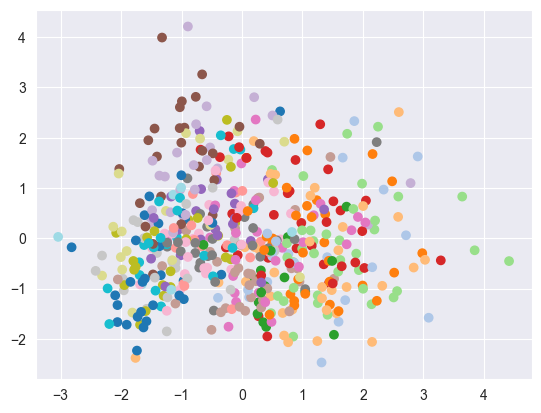

In [37]:
plt.scatter(draw_data[:, 0], draw_data[:, 1], c=y_train[perm][:500], cmap="tab20")

In [40]:
x_train_extended = np.concatenate((x_train, np.sin(x_train), np.cos(x_train)), axis=1)
x_test_extended = np.concatenate((x_test, np.sin(x_test), np.cos(x_test)), axis=1)

In [41]:
x_train_extended.shape

(11314, 300)

In [43]:
train_evaluate_model(SVC(kernel="rbf"), x_train_extended, y_train, x_test_extended, y_test)

Precision macro: 0.599731313862988
Recall macro: 0.5975955214510478
F1 macro: 0.5928444777096269
Precision micro: 0.6112586298459904
Recall micro: 0.6112586298459904
F1 micro: 0.6112586298459904
Accuracy: 0.6112586298459904
Time: 3.483166456222534


SVC()